In [1]:
from helper import *
import numpy as np
import matplotlib.pyplot as plt

import copy

In [2]:
# Import data
exmp_data = read_file('Day20_example.txt')
test_data = read_file('Day20.txt')

In [3]:
data = test_data

tiles = {}

cur_tile = []
for row in data:
    if row[:4] == 'Tile':
        name = row.split(' ')[1][:-1]
        cur_tile = []
    elif row == '':
        tiles[name] = np.array(cur_tile)
    else:
        cur_tile.append([0 if aa == '.' else 1 for aa in row])
if cur_tile != []:
    tiles[name] = np.array(cur_tile)

In [4]:
sides = {}
for key in tiles.keys():
    tt = tiles[key][0,:]
    bb = np.flip(tiles[key][-1,:])
    ll = np.flip(tiles[key][:,0])
    rr = tiles[key][:,-1]
    sides[key] = (tt, rr, bb, ll)

In [5]:
corners = []

for key in sides.keys():
    count = 0
    for side in sides[key]:
        for ot_key in sides.keys():
            if ot_key != key:
                for ot_side in sides[ot_key]:
                    if np.all(side == ot_side) \
                    or np.all(np.flip(side) == ot_side):
                        count += 1
    if count == 2:
        corners.append(key)

In [6]:
print('Part one solution: %s' %(
    int(np.prod(np.array(corners, dtype=float)))))

Part one solution: 140656720229539


# Part 2

In [7]:
corners = []
joints = []

for key in sides.keys():
    count = 0
    ii = 0
    for side in sides[key]:
        for ot_key in sides.keys():
            if ot_key != key:
                jj = 0
                for ot_side in sides[ot_key]:
                    if np.all(side == ot_side):
                        count += 1
                        joints.append((key, ot_key, ii, jj, True))
                    elif np.all(np.flip(side) == ot_side):
                        count += 1
                        joints.append((key, ot_key, ii, jj, False))
                    jj += 1
        ii += 1
    if count == 2:
        corners.append(key)

In [8]:
def get_new_rot(adj_side, side_ot, cur_rot):
    if (adj_side, side_ot) in [(0, 2), (2, 0), (1, 3), (3, 1)]:
        return 0#cur_rot
    if (adj_side, side_ot) in [(0, 1), (1, 2), (2, 3), (3, 0)]:
        return 1#(cur_rot + 1) % 4
    if (adj_side, side_ot) in [(1, 0), (2, 1), (3, 2), (0, 3)]:
        return 3#(cur_rot - 1) % 4
    if adj_side == side_ot:
        return 2#(cur_rot + 2) % 4
    
def get_adj_side(side, cur_rotate, cur_flipped):
    rotated = (side + cur_rotate) % 4
    if cur_flipped and rotated in [1, 3]:
        return (rotated + 2) % 4
    return rotated

pair_dict = {0:2, 1:3, 2:0, 3:1}

In [9]:

key = corners[0]
Nt = len(tiles)
cur_pos = (Nt//2, Nt//2)
rotation_dict = {key: 0}
cur_flipped = False
cur_rotate = 0
tile_pos = np.zeros((Nt, Nt))
tile_pos[Nt//2, Nt//2] = key
done = []
rotation_dict = {key: 0}
flip_dict = {key: False}


next_pos_dict = {0: (-1, 0),
                 1: (0, 1),
                 2: (1, 0),
                 3: (0, -1)}

candidates = [(key, cur_rotate, cur_flipped, cur_pos)]

while len(candidates) > 0:
    
    key, cur_rotate, cur_flipped, cur_pos = candidates.pop()
    if key in done:
        continue

    for tup in joints:
        if tup[0] == key and tup[1] not in done:
            _, key_ot, side, side_ot, flip = tup
            # Calculate next_pos
            # take into account flips
            adj_side = get_adj_side(side, cur_rotate, cur_flipped)

            next_xx = cur_pos[1]+next_pos_dict[adj_side][1]
            next_yy = cur_pos[0]+next_pos_dict[adj_side][0]
            if float(key_ot) in tile_pos:
                prev = np.where(float(key_ot) == tile_pos)
                assert(next_xx == prev[1][0])
                assert(next_yy == prev[0][0])
            assert(tile_pos[next_yy, next_xx] in [0, float(key_ot)])
            
            tile_pos[next_yy, next_xx] = key_ot
            next_flip = cur_flipped ^ flip
            next_rot = (pair_dict[adj_side] - side_ot) % 4
            if next_flip and (pair_dict[adj_side] in [1, 3]):
                next_rot = (next_rot + 2) % 4
        
            
    
            rotation_dict[key_ot] = next_rot
            flip_dict[key_ot] = next_flip
            candidates.append((key_ot, next_rot, next_flip,
                              (next_yy, next_xx)))
            
    done.append(key)


In [10]:
populated = tile_pos[tile_pos[:,Nt//2] > 0,:][:,tile_pos[Nt//2,:] > 0]

In [11]:
num_y, num_x = np.shape(populated)
G = 8

Dy = num_y*G
Dx = num_x*G
full_image = np.ones((Dy,Dx))*np.nan
full_image

for ii in range(num_y):
    for jj in range(num_x):
        key = str(int(populated[ii,jj]))
        cur_rot = rotation_dict[key]
        flipped = flip_dict[key]
        raw_tile = tiles[key][1:-1,1:-1]
        for _ in range(cur_rot):
            raw_tile = np.rot90(raw_tile, k=3)
        if flipped:
            raw_tile = np.flip(raw_tile, 1)
        
        full_image[G*ii:G*(ii+1),G*jj:G*(jj+1)] \
            = raw_tile

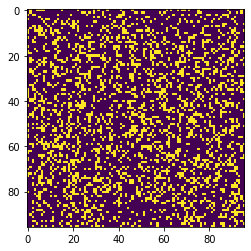

In [12]:
plt.imshow(full_image)

In [13]:
nessie_raw = read_file('nessie.txt')

In [14]:
nessie = []
for row in nessie_raw:
    nessie.append([0 if aa == ' ' else 1 for aa in row])
nessie = np.array(nessie)
h_ness, w_ness = np.shape(nessie)

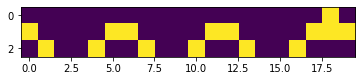

In [15]:
plt.imshow(nessie)

In [16]:
max_found = 0
rot_image = np.flip(copy.deepcopy(full_image), 0)
for _ in range(4):
    rot_image = np.rot90(rot_image, k=1)

    num_found = 0
    for h_start in range(0, Dy-h_ness):
        for w_start in range(0, Dx-w_ness):
            snip = rot_image[h_start:h_start+h_ness,w_start:w_start+w_ness]
            ma_snip = np.ma.masked_array(snip, mask=(nessie==0))
            if np.all(ma_snip == nessie):
                num_found += 1
    
    max_found = max(max_found, num_found)
print('# Nessies: %s' %max_found)

# Nessies: 37


In [17]:
score = np.count_nonzero(rot_image) - np.count_nonzero(nessie)*max_found
print('Part two solution: %s' %score)

Part two solution: 1885
